In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [2]:
from scipy.io import wavfile
from scipy import signal
from scipy.io import wavfile
from scipy.signal import butter,filtfilt
from scipy.signal import cwt
from scipy.signal import hilbert
from scipy.signal import resample
from scipy.signal import decimate
from scipy.signal import spectrogram
from scipy.signal.windows import get_window
from scipy.stats import kurtosis
from scipy.integrate import simps

import numpy as np

import librosa
import librosa.display
import matplotlib.pyplot as plt
import json
import os
import skimage.io
import cv2
import tensorflow as tf
import csv
import sklearn
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import KFold
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import IPython.display as ipd
from shutil import copyfile, copy
from sklearn.utils.class_weight import compute_class_weight
from keras import backend as K
import keras

import seaborn as sn

from collections import Counter

import pickle

from google.colab.patches import cv2_imshow

import warnings
warnings.filterwarnings("ignore")

#Model Implementation

We preliminary implement the three AI models: A multi class convolutional neural network (DTLMC), a binary class convolutional neural network (DTLBC) and a support vector machine.

In [3]:
# implementation of diagnosis clasifier architecture

class DTLMC(tf.keras.Model):

  def __init__(self):
    super(DTLMC, self).__init__()
    self.MaxPool1 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
    self.Conv1 = tf.keras.layers.Conv2D(filters = 16,kernel_size=(5,5), activation=tf.nn.relu)
    self.Conv2 = tf.keras.layers.Conv2D(filters = 16,kernel_size=(5,5), activation=tf.nn.relu)
    self.MaxPool2 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
    self.Dropout1 = tf.keras.layers.Dropout(rate = 0.15)
    self.Conv3 = tf.keras.layers.Conv2D(filters = 16,kernel_size=(5,5), activation=tf.nn.relu)
    self.Conv4 = tf.keras.layers.Conv2D(filters = 16,kernel_size=(5,5), activation=tf.nn.relu)
    self.MaxPool3 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
    self.Dropout2 = tf.keras.layers.Dropout(rate = 0.15)
    self.flatten = tf.keras.layers.Flatten()
    self.Dense1 = tf.keras.layers.Dense(256)
    self.Dropout3 = tf.keras.layers.Dropout(rate = 0.30)
    self.Dense2 = tf.keras.layers.Dense(3,activation=tf.nn.softmax)

  def call(self, inputs):
    x = self.MaxPool1(inputs)
    x = self.Conv1(x)
    x = self.Conv2(x)
    x = self.MaxPool2(x)
    x = self.Dropout1(x)
    x = self.Conv3(x)
    x = self.Conv4(x)
    x = self.MaxPool3(x)
    x = self.Dropout2(x)
    x = self.flatten(x)
    x = self.Dense1(x)
    x = self.Dropout3(x)
    x = self.Dense2(x)
    return x

class DTLBC(tf.keras.Model):

  def __init__(self):
    super(DTLBC, self).__init__()
    self.MaxPool1 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
    self.Conv1 = tf.keras.layers.Conv2D(filters = 16,kernel_size=(5,5), activation=tf.nn.relu)
    self.Conv2 = tf.keras.layers.Conv2D(filters = 16,kernel_size=(5,5), activation=tf.nn.relu)
    self.MaxPool2 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
    self.Dropout1 = tf.keras.layers.Dropout(rate = 0.15)
    self.Conv3 = tf.keras.layers.Conv2D(filters = 16,kernel_size=(5,5), activation=tf.nn.relu)
    self.Conv4 = tf.keras.layers.Conv2D(filters = 16,kernel_size=(5,5), activation=tf.nn.relu)
    self.MaxPool3 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
    self.Dropout2 = tf.keras.layers.Dropout(rate = 0.15)
    self.flatten = tf.keras.layers.Flatten()
    self.Dense1 = tf.keras.layers.Dense(256)
    self.Dropout3 = tf.keras.layers.Dropout(rate = 0.30)
    self.Dense2 = tf.keras.layers.Dense(2,activation=tf.nn.softmax)

  def call(self, inputs):
    x = self.MaxPool1(inputs)
    x = self.Conv1(x)
    x = self.Conv2(x)
    x = self.MaxPool2(x)
    x = self.Dropout1(x)
    x = self.Conv3(x)
    x = self.Conv4(x)
    x = self.MaxPool3(x)
    x = self.Dropout2(x)
    x = self.flatten(x)
    x = self.Dense1(x)
    x = self.Dropout3(x)
    x = self.Dense2(x)
    return x

class SVM():

  def __init__(self, classWeights = None):
    self.clf = sklearn.svm.SVC(kernel='linear', class_weight=classWeights)
    # other possible kernels include: "linear", "polynomial", "rbf", "sigmoid"

  def fit(self, X, y):
    self.clf.fit(X,y)

  def predict(self, X):
    return self.clf.predict(X)

  def evaluateScore(self, X_test, y_test):
    return self.clf.score(X_test, y_test)

  def getSupportVectors(self):
    return self.clf.support_vectors_

We furthermore implement a mediator class that evaluates and moderates the prediction results from all three classifiers combined.

In [4]:
class Mediator():
  '''
  The mediator class is designed to realize agreement inbetween the different classifiers.
  It returns the predicted class if all of the three classifiers agree with their prediction.
  If they do not agree, the mediator class returns a inconclusive result.
  '''
  def __init__(self, dtlmc, dtlbc, svm):
    """
    Constructor. Takes the pretrained classifiers as arguments
    dtlmc: the pretrained multiclass classifier
    dtlbc: the pretrained binaryclass classifier
    svm: the pretrained support vector machine
    """
    self.multiClassClassifier = dtlmc
    self.binaryClassClassifier = dtlbc
    self.svm = svm
  
  def encodePrediction(self, prediction):
      if prediction == 'healthy':
        return 0
      elif prediction == 'symptomatic':
        return 2
      elif prediction == 'COVID-19':
        return 1

  def predict(self, X_spectrogram, X_features):
    """
    Collects predictions from all three classifiers and medaites them into single output
    X: Features of test sample
    """
    res_dtlmc = self.multiClassClassifier.predict(X_spectrogram)
    res_dtlbc = self.binaryClassClassifier.predict(X_spectrogram)
    res_svm = self.svm.predict(X_features)

    argmax_dtlmc = np.argmax(res_dtlmc)
    argmax_dtlbc = np.argmax(res_dtlbc)
    argmax_svm = self.encodePrediction(res_svm)

    res = 2

    if argmax_dtlmc == 0 and argmax_dtlbc == 0 and argmax_svm == 0:
      res = 0
    if argmax_dtlmc == 2 and argmax_svm == 2 and argmax_dtlbc == 1:
      res = 1
    if argmax_dtlmc == 1 and argmax_svm == 1 and argmax_dtlbc == 0:
      res = 0

    return res


    def analyzeResult(self, res):
      """
      takes the result of the mediator class and translates it into human readable labels
      res: result of the predict() function of the Mediator class
      """
      if res == 0:
        return 'Covid unlikely'
      if res == 1:
        return 'Covid likely'
      if res == 2:
        return 'Test inconclusive'

In [5]:
# define two functions for one hot encoding because binary classifier needs different labels
def oneHotEncoding(labels):
  oneHotList = []
  for label in labels:
    if label == 'healthy':
      oneHotList.append([1.0,0.0,0.0])
    elif label == 'symptomatic':
      oneHotList.append([0.0,0.0,1.0])
    elif label == 'COVID-19':
      oneHotList.append([0.0,1.0,0.0])

  return np.array(oneHotList)

def oneHotEncodingForBC(labels):
  oneHotList = []
  for label in labels:
    if label == 'healthy':
      oneHotList.append([1.0,0.0])
    elif label == 'symptomatic':
      oneHotList.append([1.0,0.0])
    elif label == 'COVID-19':
      oneHotList.append([0.0,1.0])
  
  return np.array(oneHotList)

Furthermore we implement some helper functions to visualize results and learning process:

In [45]:
def plotConfusionMatrix(labellist, matrix, filename='', safeImage = False):

  df_cm = pd.DataFrame(matrix, index = [i for i in labellist],
                    columns = [i for i in labellist], dtype=float)
  fig = plt.figure(figsize = (10,7))
  sn.heatmap(df_cm, annot=True)
  if safeImage == True:
    fig.savefig('./drive/MyDrive/COUGHVID/Plots/' + filename)

def plotTrainingLoss(train_loss, val_loss):
  plt.plot(train_loss)
  plt.plot(val_loss)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train loss','test loss'], loc='upper left')
  plt.show()

def plotTrainingAccuracy(train_acc, val_acc):
  plt.plot(train_acc)
  plt.plot(val_acc)
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train accuracy', 'test accuracy'], loc='upper left')
  plt.show()


def evaluateAccuracy(X_test, y_test, metric, model):
  predictions = []
  for x in X_test:
    predArray = [0,0]
    x = np.expand_dims(x, axis=0)
    prediction = model.predict(x)
    predArray[np.argmax(prediction[0])] = 1
    predictions.append(predArray)

  metric.update_state(y_test, predictions)
  return m.result().numpy(), predictions

def getPredictions(X_test, model):
  predictions = []
  for x in X_test:
    predArray = [0,0]
    x = np.expand_dims(x, axis=0)
    prediction = model.predict(x)
    predArray[np.argmax(prediction[0])] = 1
    predictions.append(predArray)
  
  return predictions

def getAllMetrics(y_test, predictions, verbose = False):
  # simplifies splitting y_test into classes
  y_test_argmax = np.array([])
  for y in y_test:
    y_test_argmax = np.append(y_test_argmax, np.argmax(y))

  covid_indizes = np.where(y_test_argmax==1)[0]
  if verbose == True:
    print('COVID Samples: ' + str(len(covid_indizes)))
  symptom_indizes = np.where(y_test_argmax==2)[0]
  if verbose == True:
    print('Symptomatic Samples: ' + str(len(symptom_indizes)))
  healthy_indizes = np.where(y_test_argmax==0)[0]
  if verbose == True:
    print('Healthy Samples: ' + str(len(healthy_indizes)))

  tp_c = tf.keras.metrics.TruePositives()
  tn_c = tf.keras.metrics.TrueNegatives()
  fp_c = tf.keras.metrics.FalsePositives()
  fn_c = tf.keras.metrics.FalseNegatives()
  tp_c.update_state(y_test[covid_indizes], np.array(predictions)[covid_indizes])
  tn_c.update_state(y_test[covid_indizes], np.array(predictions)[covid_indizes])
  fn_c.update_state(y_test[covid_indizes], np.array(predictions)[covid_indizes])
  fp_c.update_state(y_test[covid_indizes], np.array(predictions)[covid_indizes])
  if verbose == True:
    print('True Positives for COVID Samples: ' + str(tp_c.result().numpy()))
    print('True Negatives for COVID Samples: ' + str(tn_c.result().numpy()))
    print('False Negatives for COVID Samples: ' + str(fn_c.result().numpy()))
    print('False Positives for COVID Samples: ' + str(fp_c.result().numpy()))

  tp_s = tf.keras.metrics.TruePositives()
  tn_s = tf.keras.metrics.TrueNegatives()
  fp_s = tf.keras.metrics.FalsePositives()
  fn_s = tf.keras.metrics.FalseNegatives()
  tp_s.update_state(y_test[symptom_indizes], np.array(predictions)[symptom_indizes])
  tn_s.update_state(y_test[symptom_indizes], np.array(predictions)[symptom_indizes])
  fn_s.update_state(y_test[symptom_indizes], np.array(predictions)[symptom_indizes])
  fp_s.update_state(y_test[symptom_indizes], np.array(predictions)[symptom_indizes])
  if verbose == True:
    print('True Positives for symptomatic Samples: ' + str(tp_s.result().numpy()))
    print('True Negatives for symptomatic Samples: ' + str(tn_s.result().numpy()))
    print('False Negatives for symptomatic Samples: ' + str(fn_s.result().numpy()))
    print('False Positives for symptomatic Samples: ' + str(fp_s.result().numpy()))

  tp_h = tf.keras.metrics.TruePositives()
  tn_h = tf.keras.metrics.TrueNegatives()
  fp_h = tf.keras.metrics.FalsePositives()
  fn_h = tf.keras.metrics.FalseNegatives()
  tp_h.update_state(y_test[healthy_indizes], np.array(predictions)[healthy_indizes])
  tn_h.update_state(y_test[healthy_indizes], np.array(predictions)[healthy_indizes])
  fn_h.update_state(y_test[healthy_indizes], np.array(predictions)[healthy_indizes])
  fp_h.update_state(y_test[healthy_indizes], np.array(predictions)[healthy_indizes])
  if verbose == True:
    print('True Positives for healthy samples: ' + str(tp_h.result().numpy()))
    print('True Negatives for healthy samples: ' + str(tn_h.result().numpy()))
    print('False Negatives for healthy samples: ' + str(fn_h.result().numpy()))
    print('False Positives for healthy samples: ' + str(fp_h.result().numpy()))

  sensitivity_c = tp_c.result().numpy() / (tp_c.result().numpy() + fn_c.result().numpy())
  specificity_c = tn_c.result().numpy() / (tn_c.result().numpy() + fp_c.result().numpy())
  if verbose == True:
    print('Sensitivity for the covid class: ' + str(sensitivity_c))
    print('Specificity for the covid class: ' + str(specificity_c))

  sensitivity_s = tp_s.result().numpy() / (tp_s.result().numpy() + fn_s.result().numpy())
  specificity_s = tn_s.result().numpy() / (tn_s.result().numpy() + fp_s.result().numpy())
  if verbose == True:
    print('Sensitivity for the symptom class: ' + str(sensitivity_s))
    print('Specificity for the symptom class: ' + str(specificity_s))

  sensitivity_h = tp_h.result().numpy() / (tp_h.result().numpy() + fn_h.result().numpy())
  specificity_h= tn_h.result().numpy() / (tn_h.result().numpy() + fp_h.result().numpy())
  if verbose == True:
    print('Sensitivity for the healthy class: ' + str(sensitivity_h))
    print('Specificity for the healthy class: ' + str(specificity_h))

  recall_h = tf.keras.metrics.Recall(class_id=0)
  recall_c = tf.keras.metrics.Recall(class_id=1)
  recall_s = tf.keras.metrics.Recall(class_id=2)
  recall_h.update_state(y_test, predictions)
  recall_c.update_state(y_test, predictions)
  recall_s.update_state(y_test, predictions)
  if verbose == True:
    print('Recall Healthy Samples: ' + str(recall_h.result().numpy()))
    print('Recall COVID Samples: ' + str(recall_c.result().numpy()))
    print('Recall Symptomatic Samples: ' + str(recall_s.result().numpy()))

  precision_h = tf.keras.metrics.Precision(class_id=0)
  precision_c = tf.keras.metrics.Precision(class_id=1)
  precision_s = tf.keras.metrics.Precision(class_id=2)
  precision_h.update_state(y_test, predictions)
  precision_c.update_state(y_test, predictions)
  precision_s.update_state(y_test, predictions)
  if verbose == True:
    print('Precision Healthy Samples: ' + str(precision_h.result().numpy()))
    print('Precision COVID Samples: ' + str(precision_c.result().numpy()))
    print('Precision Symptomatic Samples: ' + str(precision_s.result().numpy()))

  f1_score_h = 2*((precision_h.result().numpy()*recall_h.result().numpy())/(precision_h.result().numpy()+recall_h.result().numpy()))
  f1_score_c = 2*((precision_c.result().numpy()*recall_c.result().numpy())/(precision_c.result().numpy()+recall_c.result().numpy()))
  f1_score_s = 2*((precision_s.result().numpy()*recall_s.result().numpy())/(precision_s.result().numpy()+recall_s.result().numpy()))

  m = tf.keras.metrics.Accuracy()
  m.update_state(y_test, predictions)
  if verbose == True:
    print("Accuracy: " + str(m.result().numpy()))

  metrics_dict = {'Class':['Overall','Healthy', 'COVID', 'Symptomatic']}
  metrics_dict['F1 Score'] = ['-',f1_score_h*100, f1_score_c*100, f1_score_s*100]
  metrics_dict['Sensitivity'] = ['-',sensitivity_h*100.0,sensitivity_c*100.0,sensitivity_s*100.0]
  metrics_dict['Specificity'] = ['-',specificity_h*100.0,specificity_c*100.0,specificity_s*100.0]
  metrics_dict['Precision'] = ['-',precision_h.result().numpy()*100,precision_c.result().numpy()*100,precision_s.result().numpy()*100]
  metrics_dict['Recall'] = ['-',recall_h.result().numpy()*100,recall_c.result().numpy()*100,recall_s.result().numpy()*100]
  metrics_dict['Accuracy'] = [m.result().numpy(), '-','-','-']

  metrics_df = pd.DataFrame(data=metrics_dict)

  return metrics_df

def getAllMetricsForBC(y_test, predictions, verbose = False):
  # simplifies splitting y_test into classes
  y_test_argmax = np.array([])
  for y in y_test:
    y_test_argmax = np.append(y_test_argmax, np.argmax(y))

  covid_indizes = np.where(y_test_argmax==1)[0]
  if verbose == True:
    print('COVID Samples: ' + str(len(covid_indizes)))
  healthy_indizes = np.where(y_test_argmax==0)[0]
  if verbose == True:
    print('No COVID Samples: ' + str(len(healthy_indizes)))

  tp_c = tf.keras.metrics.TruePositives()
  tn_c = tf.keras.metrics.TrueNegatives()
  fp_c = tf.keras.metrics.FalsePositives()
  fn_c = tf.keras.metrics.FalseNegatives()
  tp_c.update_state(y_test[covid_indizes], np.array(predictions)[covid_indizes])
  tn_c.update_state(y_test[covid_indizes], np.array(predictions)[covid_indizes])
  fn_c.update_state(y_test[covid_indizes], np.array(predictions)[covid_indizes])
  fp_c.update_state(y_test[covid_indizes], np.array(predictions)[covid_indizes])
  if verbose == True:
    print('True Positives for COVID Samples: ' + str(tp_c.result().numpy()))
    print('True Negatives for COVID Samples: ' + str(tn_c.result().numpy()))
    print('False Negatives for COVID Samples: ' + str(fn_c.result().numpy()))
    print('False Positives for COVID Samples: ' + str(fp_c.result().numpy()))

  tp_h = tf.keras.metrics.TruePositives()
  tn_h = tf.keras.metrics.TrueNegatives()
  fp_h = tf.keras.metrics.FalsePositives()
  fn_h = tf.keras.metrics.FalseNegatives()
  tp_h.update_state(y_test[healthy_indizes], np.array(predictions)[healthy_indizes])
  tn_h.update_state(y_test[healthy_indizes], np.array(predictions)[healthy_indizes])
  fn_h.update_state(y_test[healthy_indizes], np.array(predictions)[healthy_indizes])
  fp_h.update_state(y_test[healthy_indizes], np.array(predictions)[healthy_indizes])
  if verbose == True:
    print('True Positives for healthy samples: ' + str(tp_h.result().numpy()))
    print('True Negatives for healthy samples: ' + str(tn_h.result().numpy()))
    print('False Negatives for healthy samples: ' + str(fn_h.result().numpy()))
    print('False Positives for healthy samples: ' + str(fp_h.result().numpy()))

  sensitivity_c = tp_c.result().numpy() / (tp_c.result().numpy() + fn_c.result().numpy())
  specificity_c = tn_c.result().numpy() / (tn_c.result().numpy() + fp_c.result().numpy())
  if verbose == True:
    print('Sensitivity for the covid class: ' + str(sensitivity_c))
    print('Specificity for the covid class: ' + str(specificity_c))

  sensitivity_h = tp_h.result().numpy() / (tp_h.result().numpy() + fn_h.result().numpy())
  specificity_h= tn_h.result().numpy() / (tn_h.result().numpy() + fp_h.result().numpy())
  if verbose == True:
    print('Sensitivity for the healthy class: ' + str(sensitivity_h))
    print('Specificity for the healthy class: ' + str(specificity_h))

  recall_h = tf.keras.metrics.Recall(class_id=0)
  recall_c = tf.keras.metrics.Recall(class_id=1)
  recall_h.update_state(y_test, predictions)
  recall_c.update_state(y_test, predictions)
  if verbose == True:
    print('Recall Healthy Samples: ' + str(recall_h.result().numpy()))
    print('Recall COVID Samples: ' + str(recall_c.result().numpy()))

  precision_h = tf.keras.metrics.Precision(class_id=0)
  precision_c = tf.keras.metrics.Precision(class_id=1)
  precision_h.update_state(y_test, predictions)
  precision_c.update_state(y_test, predictions)
  if verbose == True:
    print('Precision Healthy Samples: ' + str(precision_h.result().numpy()))
    print('Precision COVID Samples: ' + str(precision_c.result().numpy()))

  f1_score_h = 2*((precision_h.result().numpy()*recall_h.result().numpy())/(precision_h.result().numpy()+recall_h.result().numpy()))
  f1_score_c = 2*((precision_c.result().numpy()*recall_c.result().numpy())/(precision_c.result().numpy()+recall_c.result().numpy()))

  m = tf.keras.metrics.Accuracy()
  m.update_state(y_test, predictions)
  if verbose == True:
    print("Accuracy: " + str(m.result().numpy()))

  metrics_dict = {'Class':['Overall','Healthy', 'COVID']}
  metrics_dict['F1 Score'] = ['-',f1_score_h*100, f1_score_c*100]
  metrics_dict['Sensitivity'] = ['-',sensitivity_h*100.0,sensitivity_c*100.0]
  metrics_dict['Specificity'] = ['-',specificity_h*100.0,specificity_c*100.0]
  metrics_dict['Precision'] = ['-',precision_h.result().numpy()*100,precision_c.result().numpy()*100]
  metrics_dict['Recall'] = ['-',recall_h.result().numpy()*100,recall_c.result().numpy()*100]
  metrics_dict['Accuracy'] = [m.result().numpy(), '-','-']

  metrics_df = pd.DataFrame(data=metrics_dict)

  return metrics_df
  

#Evaluation on whole cough samples

In [ ]:
def valueFromJsonParser(fileName, key, path='./drive/MyDrive/COUGHVID/test_dset/'):
    """
    Returns the status of the specified json file 
    """    
    with open(os.path.join(path, fileName)) as file:
        data = json.load(file)
        return data[str(key)]


def loadMelspectrograms(path, jsonFilesPath):
  data = []
  labels = []
  for (dirpath, dirnames, filenames) in os.walk(path):
    for filename in filenames[0:4000]:
      img = cv2.imread(path + filename)
      data.append(img)
  for (dirpath,dirnames,filenames) in os.walk(jsonFilesPath):
    for filename in filenames[0:8000]:
      if '.json' in filename:
        label = valueFromJsonParser(fileName=filename, key='status', path=jsonFilesPath)
        labels.append(label)

  return np.float32(np.array(data)), np.array(labels)

In [ ]:
data, labels = loadMelspectrograms('./drive/MyDrive/COUGHVID/MelSpectrogramsCleaned/', './drive/MyDrive/COUGHVID/public_dataset_cleaned/')

In [ ]:
X, Y = data, oneHotEncoding(labels)

In [ ]:
print(data.shape)

Perform Class Balancing:

In [ ]:
''' counter = [0,0,0]
for label in labels:
  if label == 'healthy':
    counter[0] += 1
  if label == "symptomatic":
    counter[1] += 1
  if label == 'COVID-19':
    counter[2] += 1

print(counter)
 '''
covid_indizes = np.where(labels=='COVID-19')
print(len(covid_indizes[0]))
symptom_indizes = np.where(labels=='symptomatic')
print(len(symptom_indizes[0]))
healthy_indizes = np.where(labels=='healthy')
print(len(healthy_indizes[0]))

In [ ]:
data_new = data[covid_indizes]
data_new = np.append(data_new,data[symptom_indizes[0][:364]], axis=0)
data_new = np.append(data_new,data[healthy_indizes[0][:364]], axis=0)

labels_new = labels[covid_indizes]
labels_new = np.append(labels_new,labels[symptom_indizes[0][:364]])
labels_new = np.append(labels_new,labels[healthy_indizes[0][:364]])

labels_new = oneHotEncoding(labels_new)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_new, labels_new, test_size=0.25, random_state=0)

dtlmc = DTLMC()
dtlmc.compile(optimizer='adam',loss='categorical_crossentropy')
dtlmc.fit(X_train,y_train, epochs=20)

In [ ]:
dtlmc.evaluate(X_test, y_test)

In [ ]:
predictions = []
for x in X_test:
  predArray = [0,0,0]
  x = np.expand_dims(x, axis=0)
  prediction = dtlmc.predict(x)
  print(prediction)
  predArray[np.argmax(prediction)] = 1
  predictions.append(predArray)

In [ ]:
m = tf.keras.metrics.Accuracy()
m.update_state(y_test, predictions)
m.result().numpy()

In [ ]:
matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))

In [ ]:
print(matrix)

#Evaluation on segmented data

Load the melspecs of segmented data from drive

In [30]:
dataSegmented = np.load('./drive/MyDrive/COUGHVID/melSpecsDataSegmented.npy', allow_pickle=True)
labels = np.load('./drive/MyDrive/COUGHVID/melSpecsLabelsSegmented.npy', allow_pickle=True)

In [31]:
print(dataSegmented.shape)
print(labels.shape)

(24374, 240, 320)
(24374,)


##Evaluation with class weights

###Evaluation of the multi class clasifier


In [ ]:
labels_new_mc = oneHotEncoding(labels)
data_new = np.expand_dims(dataSegmented, axis=3)

In [ ]:
print(labels_new_mc.shape)
print(data_new.shape)

(24374, 3)
(24374, 240, 320, 1)


In [ ]:
# split data for train and test validation
X_train, X_test, y_train, y_test = train_test_split(data_new, labels_new_mc, test_size=0.2, random_state=0)


## calculate class weights
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
class_weights_dict = dict(enumerate(class_weights))

class_weights_dict

{0: 0.4392853924484095, 1: 4.075026123301986, 2: 2.0912698412698414}

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.00001,
    decay_steps=10000,
    decay_rate=0.9)

cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=25, verbose=1,
    mode='auto', baseline=None, restore_best_weights=True)

dtlmc = DTLMC()
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
dtlmc.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['acc'])


In [ ]:
history = dtlmc.fit(X_train,y_train, epochs=250, validation_data=(X_test,y_test), class_weight=class_weights_dict, callbacks=[cb])

Epoch 1/250
610/610 [==============================] - 32s 22ms/step - loss: 1.7831 - acc: 0.3388 - val_loss: 1.2077 - val_acc: 0.2045
Epoch 2/250
610/610 [==============================] - 11s 18ms/step - loss: 1.2032 - acc: 0.3456 - val_loss: 1.0730 - val_acc: 0.4320
Epoch 3/250
610/610 [==============================] - 11s 17ms/step - loss: 1.1365 - acc: 0.3620 - val_loss: 1.1155 - val_acc: 0.3210
Epoch 4/250
610/610 [==============================] - 11s 18ms/step - loss: 1.1098 - acc: 0.3758 - val_loss: 1.0971 - val_acc: 0.3721
Epoch 5/250
610/610 [==============================] - 11s 18ms/step - loss: 1.1046 - acc: 0.3751 - val_loss: 1.0931 - val_acc: 0.3774
Epoch 6/250
610/610 [==============================] - 11s 18ms/step - loss: 1.0890 - acc: 0.3856 - val_loss: 1.1209 - val_acc: 0.3138
Epoch 7/250
610/610 [==============================] - 11s 18ms/step - loss: 1.0851 - acc: 0.3945 - val_loss: 1.0831 - val_acc: 0.3938
Epoch 8/250
610/610 [==============================] - 

In [ ]:
dtlmc.save('./drive/MyDrive/COUGHVID/Models/dtlmc', save_format="tf")

INFO:tensorflow:Assets written to: ./drive/MyDrive/COUGHVID/Models/dtlmc/assets


In [ ]:
predictions = []
for x in X_test:
  predArray = [0,0,0]
  x = np.expand_dims(x, axis=0)
  prediction = dtlmc.predict(x)
  predArray[np.argmax(prediction[0])] = 1
  predictions.append(predArray)

In [ ]:
df = getAllMetrics(y_test, predictions)
df

COVID Samples: 389
Symptomatic Samples: 796
Healthy Samples: 3690
True Positives for COVID Samples: 102.0
True Negatives for COVID Samples: 491.0
False Negatives for COVID Samples: 287.0
False Positives for COVID Samples: 287.0
True Positives for symptomatic Samples: 303.0
True Negatives for symptomatic Samples: 1099.0
False Negatives for symptomatic Samples: 493.0
False Positives for symptomatic Samples: 493.0
True Positives for healthy samples: 2186.0
True Negatives for healthy samples: 5876.0
False Negatives for healthy samples: 1504.0
False Positives for healthy samples: 1504.0
Sensitivity for the covid class: 0.2622108
Specificity for the covid class: 0.6311054
Sensitivity for the symptom class: 0.38065326
Specificity for the symptom class: 0.69032663
Sensitivity for the healthy class: 0.59241194
Specificity for the healthy class: 0.79620594
Recall Healthy Samples: 0.59241194
Recall COVID Samples: 0.2622108
Recall Symptomatic Samples: 0.38065326
Precision Healthy Samples: 0.799853

,Class,F1 Score,Sensitivity,Specificity,Precision,Recall,Accuracy
0,Overall,-,-,-,-,-,0.687658
1,Healthy,68.0679,59.2412,79.6206,79.9854,59.2412,-
2,COVID,15.2125,26.2211,63.1105,10.7143,26.2211,-
3,Symptomatic,30.5136,38.0653,69.0327,25.4622,38.0653,-


In [ ]:
matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))

In [ ]:
matrix = matrix/matrix.sum(axis=1)[:, np.newaxis]

In [ ]:
matrix

array([[0.59241192, 0.18807588, 0.2195122 ],
       [0.53984576, 0.2622108 , 0.19794344],
       [0.42336683, 0.1959799 , 0.38065327]])

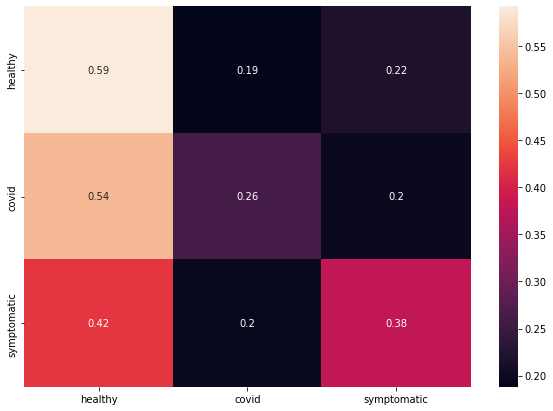

In [ ]:
labellist = ['healthy','covid', 'symptomatic']
plotConfusionMatrix(labellist, matrix)

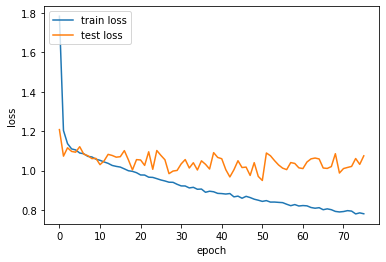

In [ ]:
plotTrainingLoss(history.history['loss'], history.history['val_loss'])

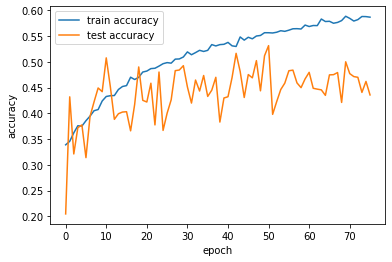

In [ ]:
plotTrainingAccuracy(history.history['acc'], history.history['val_acc'])

###Evaluation of the binary class classifier

In [ ]:
labels_new_bc = oneHotEncodingForBC(labels)
data_new_bc = np.expand_dims(dataSegmented, axis=3)
print(data_new_bc.shape)
print(labels_new_bc.shape)

(24374, 240, 320, 1)
(24374, 2)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_new_bc, labels_new_bc, test_size=0.2, random_state=0)

In [ ]:
## calculate class weights
y_integers = np.argmax(y_train, axis=1)
class_weights_bc = compute_class_weight('balanced', np.unique(y_integers), y_integers)
class_weights_dict_bc = dict(enumerate(class_weights_bc))

class_weights_dict_bc

{0: 0.5445431188561215, 1: 6.112539184952978}

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.000001,
    decay_steps=10000,
    decay_rate=0.9)

cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=25, verbose=1,
    mode='auto', baseline=None, restore_best_weights=True)

In [ ]:
dtlbc = DTLBC()
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
dtlbc.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['acc'])

In [ ]:
history = dtlbc.fit(X_train,y_train, epochs=250, validation_data=(X_test,y_test), class_weight=class_weights_dict_bc, callbacks=[cb])

Epoch 1/250
610/610 [==============================] - 20s 32ms/step - loss: 1.5832 - acc: 0.5196 - val_loss: 1.1114 - val_acc: 0.1366
Epoch 2/250
610/610 [==============================] - 16s 26ms/step - loss: 1.3995 - acc: 0.5038 - val_loss: 0.9787 - val_acc: 0.1863
Epoch 3/250
610/610 [==============================] - 16s 26ms/step - loss: 1.2434 - acc: 0.5008 - val_loss: 0.9288 - val_acc: 0.1957
Epoch 4/250
610/610 [==============================] - 16s 26ms/step - loss: 1.1466 - acc: 0.5115 - val_loss: 0.9050 - val_acc: 0.1947
Epoch 5/250
610/610 [==============================] - 16s 26ms/step - loss: 1.0780 - acc: 0.5069 - val_loss: 0.8808 - val_acc: 0.2055
Epoch 6/250
610/610 [==============================] - 16s 26ms/step - loss: 1.0102 - acc: 0.5129 - val_loss: 0.8006 - val_acc: 0.3102
Epoch 7/250
610/610 [==============================] - 16s 26ms/step - loss: 0.9790 - acc: 0.5038 - val_loss: 0.7674 - val_acc: 0.3571
Epoch 8/250
610/610 [==============================] - 

In [ ]:
dtlbc.save('./drive/MyDrive/COUGHVID/Models/dtlbc', save_format="tf")

INFO:tensorflow:Assets written to: ./drive/MyDrive/COUGHVID/Models/dtlbc/assets


In [ ]:
predictions = getPredictions(y_test, dtlbc)

In [ ]:
results = getAllMetricsForBC(y_test, predictions)
results

COVID Samples: 389
No COVID Samples: 4486
True Positives for COVID Samples: 125.0
True Negatives for COVID Samples: 125.0
False Negatives for COVID Samples: 264.0
False Positives for COVID Samples: 264.0
True Positives for healthy samples: 3209.0
True Negatives for healthy samples: 3209.0
False Negatives for healthy samples: 1277.0
False Positives for healthy samples: 1277.0
Sensitivity for the covid class: 0.32133675
Specificity for the covid class: 0.32133675
Sensitivity for the healthy class: 0.7153366
Specificity for the healthy class: 0.7153366
Recall Healthy Samples: 0.7153366
Recall COVID Samples: 0.32133675
Precision Healthy Samples: 0.923985
Precision COVID Samples: 0.08915835
Accuracy: 0.68389744


,Class,F1 Score,Sensitivity,Specificity,Precision,Recall,Accuracy
0,Overall,-,-,-,-,-,0.683897
1,Healthy,80.6383,71.5337,71.5337,92.3985,71.5337,-
2,COVID,13.9587,32.1337,32.1337,8.91583,32.1337,-


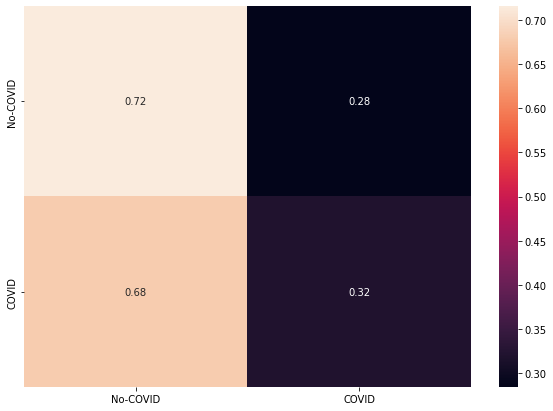

In [ ]:
matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), normalize='true')
labellist = ['No-COVID', 'COVID']
plotConfusionMatrix(labellist, matrix)

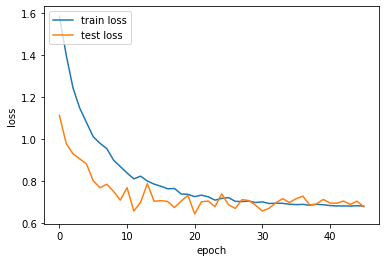

In [ ]:
plotTrainingLoss(history.history['loss'], history.history['val_loss'])

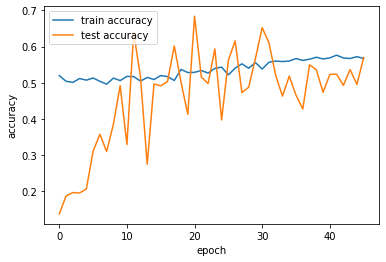

In [ ]:
plotTrainingAccuracy(history.history['acc'], history.history['val_acc'])

As we can see, the model clearly overfits since the train accuracy increases while the test accuracy stays more or less the same.

###Evaluation of the SVM

In [7]:
features_svm = np.load('./drive/MyDrive/COUGHVID/mfccfeatures.npy', allow_pickle=True)
labels_svm = np.load('./drive/MyDrive/COUGHVID/mfccfeatureslabels.npy', allow_pickle=True)
print(features_svm.shape)
print(labels_svm.shape)

(23490, 256)
(23490,)


In [17]:
np.unique(labels_svm)

array(['COVID-19', 'healthy', 'symptomatic'], dtype=object)

In [19]:
## calculate class weights
class_weights_svm = compute_class_weight('balanced', np.unique(labels_svm), labels_svm)
class_weights_dict_svm = {'COVID-19':class_weights_svm[0], 'healthy':class_weights_svm[1], 'symptomatic':class_weights_svm[2]}

class_weights_dict_svm

{'COVID-19': 4.042333505420753,
 'healthy': 0.4403824521934758,
 'symptomatic': 2.0752716671084017}

In [23]:
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(features_svm, labels_svm, test_size=0.2, random_state=0)

In [24]:
svm = SVM(classWeights=class_weights_dict_svm)
svm.fit(X_train_svm, y_train_svm)

In [25]:
predictions = []
for x in X_test_svm:
  X = np.expand_dims(x, axis=0)
  predictions.append(svm.predict(X)[0])
predictions_oneHot = oneHotEncoding(predictions)
y_test_svm_oneHot = oneHotEncoding(y_test_svm)

In [26]:
results = getAllMetrics(y_test_svm_oneHot, predictions_oneHot)
results

,Class,F1 Score,Sensitivity,Specificity,Precision,Recall,Accuracy
0,Overall,-,-,-,-,-,0.629333
1,Healthy,57.5944,43.8503,71.9251,83.8875,43.8503,-
2,COVID,19.5251,41.573,70.7865,12.7586,41.573,-
3,Symptomatic,32.7801,48.4663,74.2331,24.7649,48.4663,-


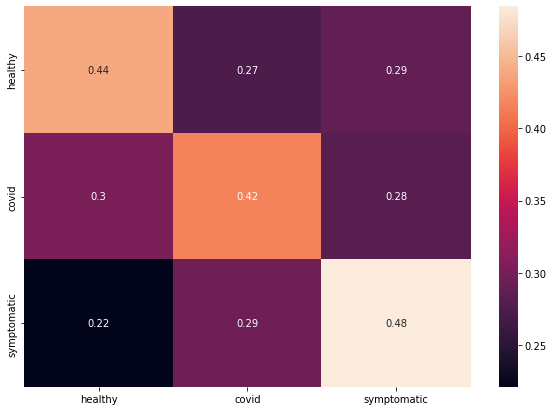

In [29]:
matrix = confusion_matrix(np.argmax(oneHotEncoding(y_test_svm), axis=1), np.argmax(oneHotEncoding(predictions), axis=1), normalize="true")
labellist = ['healthy','covid', 'symptomatic']
plotConfusionMatrix(labellist, matrix)

##Evaluation with balanced datasets

In [33]:
covid_indizes = np.where(labels=='COVID-19')
print('COVID Samples: ' + str(len(covid_indizes[0])))
symptom_indizes = np.where(labels=='symptomatic')
print('Symptomatic Samples: ' + str(len(symptom_indizes[0])))
healthy_indizes = np.where(labels=='healthy')
print('Healthy Samples: ' + str(len(healthy_indizes[0])))

COVID Samples: 1984
Symptomatic Samples: 3904
Healthy Samples: 18486


As we can see the dataset is highly unbalanced. Therefor we take from each class only the amount of samples that we have available of the most underrepresented class.

##Evaluation of DTLMC

In [ ]:
data_new = dataSegmented[covid_indizes]
data_new = np.append(data_new,dataSegmented[symptom_indizes[0][:len(covid_indizes[0])]], axis=0)
data_new = np.append(data_new,dataSegmented[healthy_indizes[0][:len(covid_indizes[0])]], axis=0)

data_new = np.expand_dims(data_new, axis=3)

labels_new = labels[covid_indizes]
labels_new = np.append(labels_new,labels[symptom_indizes[0][:len(covid_indizes[0])]])
labels_new = np.append(labels_new,labels[healthy_indizes[0][:len(covid_indizes[0])]])

labels_new = oneHotEncoding(labels_new)

print(labels_new.shape)
print(data_new.shape)

(5952, 3)
(5952, 240, 320, 1)


In [ ]:
# split data for train and test validation
X_train, X_test, y_train, y_test = train_test_split(data_new, labels_new, test_size=0.2, random_state=0)

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.00001,
    decay_steps=10000,
    decay_rate=0.9)

cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=25, verbose=1,
    mode='auto', baseline=None, restore_best_weights=True)

dtlmc = DTLMC()
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
dtlmc.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['acc'])


In [ ]:
history = dtlmc.fit(X_train,y_train, epochs=250, validation_data=(X_test,y_test), callbacks=[cb])

Epoch 1/250
149/149 [==============================] - 5s 30ms/step - loss: 6.1886 - acc: 0.3369 - val_loss: 1.3505 - val_acc: 0.3417
Epoch 2/250
149/149 [==============================] - 4s 25ms/step - loss: 3.1049 - acc: 0.3262 - val_loss: 1.1732 - val_acc: 0.3493
Epoch 3/250
149/149 [==============================] - 4s 25ms/step - loss: 2.0019 - acc: 0.3451 - val_loss: 1.1388 - val_acc: 0.3577
Epoch 4/250
149/149 [==============================] - 4s 25ms/step - loss: 1.5124 - acc: 0.3550 - val_loss: 1.1195 - val_acc: 0.3644
Epoch 5/250
149/149 [==============================] - 4s 25ms/step - loss: 1.3571 - acc: 0.3535 - val_loss: 1.1102 - val_acc: 0.3543
Epoch 6/250
149/149 [==============================] - 4s 25ms/step - loss: 1.2574 - acc: 0.3482 - val_loss: 1.1075 - val_acc: 0.3594
Epoch 7/250
149/149 [==============================] - 4s 25ms/step - loss: 1.2217 - acc: 0.3573 - val_loss: 1.1009 - val_acc: 0.3745
Epoch 8/250
149/149 [==============================] - 4s 25ms

In [ ]:
predictions = []
for x in X_test:
  predArray = [0,0,0]
  x = np.expand_dims(x, axis=0)
  prediction = dtlmc.predict(x)
  predArray[np.argmax(prediction[0])] = 1
  predictions.append(predArray)

In [ ]:
df = getAllMetrics(y_test, predictions)
df

,Class,F1 Score,Sensitivity,Specificity,Precision,Recall,Accuracy
0,Overall,-,-,-,-,-,0.603135
1,Healthy,43.4298,49.1184,74.5592,38.9222,49.1184,-
2,COVID,36.9844,34.3008,67.1504,40.1235,34.3008,-
3,Symptomatic,40.2049,37.8313,68.9157,42.8962,37.8313,-


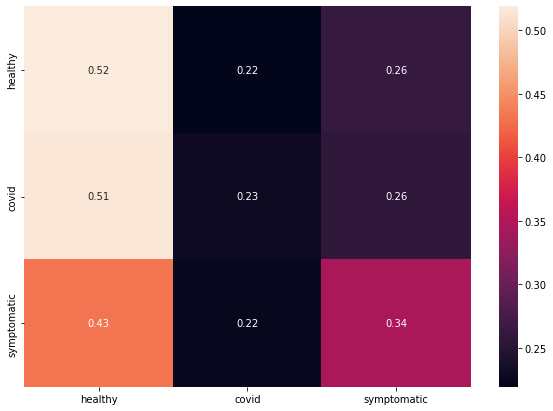

In [ ]:
matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), normalize="true")
labellist = ['healthy','covid', 'symptomatic']
plotConfusionMatrix(labellist, matrix)

##Evaluation of DTLBC

In [55]:
data_new = dataSegmented[covid_indizes]
data_new = np.append(data_new,dataSegmented[symptom_indizes[0][:int((len(covid_indizes[0])/2))]], axis=0)
data_new = np.append(data_new,dataSegmented[healthy_indizes[0][:int((len(covid_indizes[0])/2))]], axis=0)

data_new = np.expand_dims(data_new, axis=3)

labels_new = labels[covid_indizes]
labels_new = np.append(labels_new,labels[symptom_indizes[0][:int((len(covid_indizes[0])/2))]])
labels_new = np.append(labels_new,labels[healthy_indizes[0][:int((len(covid_indizes[0])/2))]])

labels_new = oneHotEncodingForBC(labels_new)

print(labels_new.shape)
print(data_new.shape)

(3968, 2)
(3968, 240, 320, 1)


In [59]:
assert labels_new.shape[0]/2 == len(covid_indizes[0])

In [60]:
X_train, X_test, y_train, y_test = train_test_split(data_new, labels_new, test_size=0.2, random_state=0)

In [61]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.00001,
    decay_steps=10000,
    decay_rate=0.9)

cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=25, verbose=1,
    mode='auto', baseline=None, restore_best_weights=True)

dtlbc = DTLBC()
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
dtlbc.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['acc'])

In [62]:
history = dtlbc.fit(X_train,y_train, epochs=250, validation_data=(X_test,y_test), callbacks=[cb])

Epoch 1/250
100/100 [==============================] - 3s 23ms/step - loss: 9.0131 - acc: 0.5113 - val_loss: 5.7866 - val_acc: 0.4824
Epoch 2/250
100/100 [==============================] - 2s 17ms/step - loss: 5.7442 - acc: 0.5057 - val_loss: 1.9079 - val_acc: 0.4836
Epoch 3/250
100/100 [==============================] - 2s 17ms/step - loss: 3.8548 - acc: 0.5148 - val_loss: 1.5721 - val_acc: 0.4874
Epoch 4/250
100/100 [==============================] - 2s 17ms/step - loss: 3.0264 - acc: 0.5113 - val_loss: 1.4620 - val_acc: 0.4861
Epoch 5/250
100/100 [==============================] - 2s 17ms/step - loss: 2.3498 - acc: 0.4946 - val_loss: 1.0394 - val_acc: 0.4950
Epoch 6/250
100/100 [==============================] - 2s 17ms/step - loss: 1.8290 - acc: 0.4924 - val_loss: 1.1244 - val_acc: 0.4912
Epoch 7/250
100/100 [==============================] - 2s 17ms/step - loss: 1.4653 - acc: 0.5104 - val_loss: 0.9336 - val_acc: 0.4950
Epoch 8/250
100/100 [==============================] - 2s 17ms

In [63]:
predictions = getPredictions(X_test, dtlbc)

In [64]:
results = getAllMetricsForBC(y_test, predictions)
results

,Class,F1 Score,Sensitivity,Specificity,Precision,Recall,Accuracy
0,Overall,-,-,-,-,-,0.566751
1,Healthy,55.5556,56.1358,56.1358,54.9872,56.1358,-
2,COVID,57.7396,57.1776,57.1776,58.3127,57.1776,-


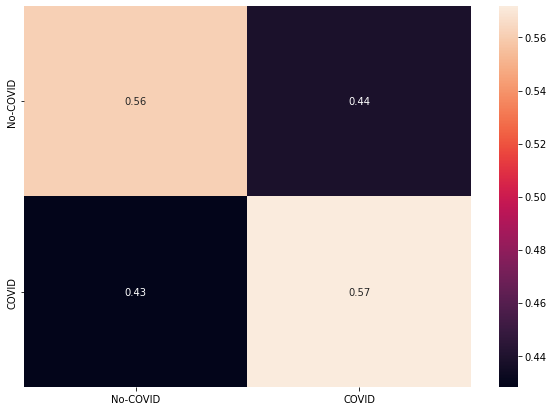

In [65]:
matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), normalize='true')
labellist = ['No-COVID', 'COVID']
plotConfusionMatrix(labellist, matrix)

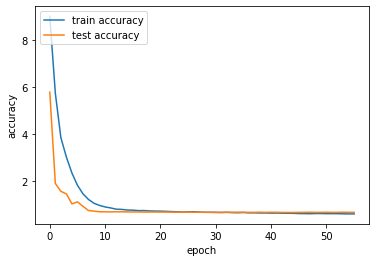

In [67]:
plotTrainingLoss(history.history['loss'], history.history['val_loss'])

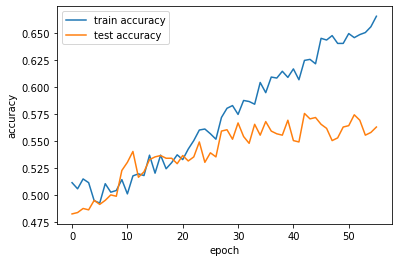

In [69]:
plotTrainingAccuracy(history.history['acc'], history.history['val_acc'])

This shows that the class balancing approach does not perform better for the DTLBC. The results are not remarkably better than guessing. This is most likely due to the fact that the dataset is too small for the NN to learn features.

##Evaluation of the Support Vector Machine classifier

In [ ]:
features_svm = np.load('./drive/MyDrive/COUGHVID/mfccfeatures.npy', allow_pickle=True)
labels_svm = np.load('./drive/MyDrive/COUGHVID/mfccfeatureslabels.npy', allow_pickle=True)

In [ ]:
print(features_svm.shape)
print(labels_svm.shape)

(23490, 256)
(23490,)


Perform class balancing by hand. This is not too huge of a problem because SVMs should perform well an small datasets aswell.

In [ ]:
covid_indizes = np.where(labels_svm=='COVID-19')
print(len(covid_indizes[0]))
symptom_indizes = np.where(labels_svm=='symptomatic')
print(len(symptom_indizes[0]))
healthy_indizes = np.where(labels_svm=='healthy')
print(len(healthy_indizes[0]))

1937
3773
17780


In [ ]:
data_new_svm = features_svm[covid_indizes]
data_new_svm = np.append(data_new_svm,features_svm[symptom_indizes[0][:len(covid_indizes[0])]], axis=0)
data_new_svm = np.append(data_new_svm,features_svm[healthy_indizes[0][:len(covid_indizes[0])]], axis=0)


labels_new_svm = labels_svm[covid_indizes]
labels_new_svm = np.append(labels_new_svm,labels_svm[symptom_indizes[0][:len(covid_indizes[0])]])
labels_new_svm = np.append(labels_new_svm,labels_svm[healthy_indizes[0][:len(covid_indizes[0])]])

In [ ]:
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(data_new_svm, labels_new_svm, test_size=0.2, random_state=0)

In [ ]:
svm = SVM()
svm.fit(X_train_svm, y_train_svm)

In [ ]:
pickle.dump(svm, open('./drive/MyDrive/COUGHVID/Models/svm', 'wb'))

In [ ]:
predictions = []
for x in X_test_svm:
  X = np.expand_dims(x, axis=0)
  predictions.append(svm.predict(X)[0])

In [ ]:
predictions_oneHot = oneHotEncoding(predictions)
y_test_svm_oneHot = oneHotEncoding(y_test_svm)

In [ ]:
results = getAllMetrics(y_test_svm_oneHot, predictions_oneHot)
results

COVID Samples: 377
Symptomatic Samples: 384
Healthy Samples: 402
True Positives for COVID Samples: 182.0
True Negatives for COVID Samples: 559.0
False Negatives for COVID Samples: 195.0
False Positives for COVID Samples: 195.0
True Positives for symptomatic Samples: 165.0
True Negatives for symptomatic Samples: 549.0
False Negatives for symptomatic Samples: 219.0
False Positives for symptomatic Samples: 219.0
True Positives for healthy samples: 155.0
True Negatives for healthy samples: 557.0
False Negatives for healthy samples: 247.0
False Positives for healthy samples: 247.0
Sensitivity for the covid class: 0.4827586
Specificity for the covid class: 0.7413793
Sensitivity for the symptom class: 0.4296875
Specificity for the symptom class: 0.71484375
Sensitivity for the healthy class: 0.38557214
Specificity for the healthy class: 0.6927861
Recall Healthy Samples: 0.38557214
Recall COVID Samples: 0.4827586
Recall Symptomatic Samples: 0.4296875
Precision Healthy Samples: 0.44159544
Precis

,Class,F1 Score,Sensitivity,Specificity,Precision,Recall,Accuracy
0,Overall,-,-,-,-,-,0.621095
1,Healthy,41.1687,38.5572,69.2786,44.1595,38.5572,-
2,COVID,44.1212,48.2759,74.1379,40.625,48.2759,-
3,Symptomatic,44.1176,42.9688,71.4844,45.3297,42.9688,-


As we can see, the SVM classifier performs slightly better than pure guessing. We can further analyse the results bei taking a look at the confusion matrix. 

In [ ]:
predictions = oneHotEncoding(predictions)

In [ ]:
y_test_oneHot = oneHotEncoding(y_test_svm)

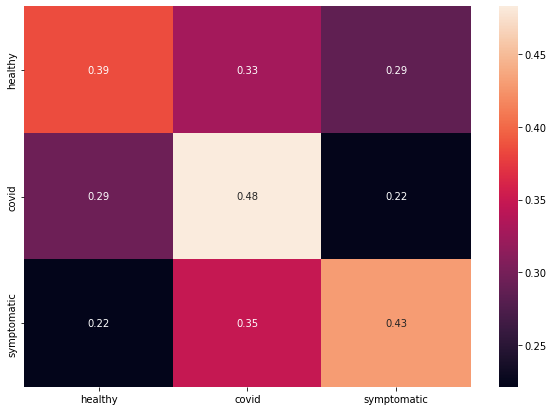

In [ ]:
matrix = confusion_matrix(np.argmax(y_test_oneHot, axis=1), np.argmax(predictions, axis=1), normalize="true")
labellist = ['healthy','covid', 'symptomatic']
plotConfusionMatrix(labellist, matrix)

## Evaluation of the entire mediator

Load trained classifiers from drive:

In [ ]:
dtlmc = new_model = tf.keras.models.load_model('./drive/MyDrive/COUGHVID/Models/dtlmc')
dtlbc = tf.keras.models.load_model('./drive/MyDrive/COUGHVID/Models/dtlbc')
svm = pickle.load(open('./drive/MyDrive/COUGHVID/Models/svm','rb'))

In [ ]:
mediator = Mediator(dtlmc, dtlbc, svm)

In [ ]:
X_spectrograms = np.load('./drive/MyDrive/COUGHVID/EvaluationSet/evaluationMelspecs.npy', allow_pickle=True)
X_features = np.load('./drive/MyDrive/COUGHVID/EvaluationSet/evaluationFeatures.npy', allow_pickle=True)
labels = np.load('./drive/MyDrive/COUGHVID/EvaluationSet/evaluationLabels.npy', allow_pickle=True)

In [ ]:
print(X_spectrograms.shape)
print(X_features.shape)

(600, 240, 320, 1)
(600, 256)


In [ ]:
results = [] 
for index in range(0,600):
  spectrogram = np.expand_dims(X_spectrograms[index], axis=0)
  features=np.expand_dims(X_features[index], axis=0)
  result = mediator.predict(spectrogram, features)
  results.append(result)



In [ ]:
Counter(results)

Counter({0: 223, 2: 377})

In [ ]:
Counter(labels)

Counter({'COVID-19': 52, 'healthy': 455, 'symptomatic': 93})

We can see that the mediator class never predicts a COVID infection because inter classifier agreement is too never given. This is not surprising considering the low precission for COVID infections the classifiers score.